In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
usr_segment = pd.read_csv("Jun_segmentation.csv")
features = pd.read_csv("features.csv")
openapp_recency = pd.read_csv("openapp_recency.csv")

In [81]:
## merge dataset
merged_1 = pd.merge(usr_segment, features, on='user_sn', how='inner')
merged_2 = pd.merge(merged_1, openapp_recency, on='user_sn', how='inner')

In [82]:
## Fill the null values with 0 for open_app_num_3_months, mileage_used_num, current_mileage_point
## search_num_3_months, review_num_3_months, avg_mark
merged_2[['open_app_num_3_months', 'mileage_used_num', 'current_mileage_point', 
          'review_num_3_months','search_num_3_months']] = merged_2[['open_app_num_3_months', 'mileage_used_num', 'current_mileage_point',
                                                            'review_num_3_months','search_num_3_months',]].fillna(0).astype('int64')

merged_2['avg_mark'] = merged_2['avg_mark'].fillna(0).astype('float32')

In [83]:
# Get rid of records with time_since_join or average_ci_time_gap < 0 and records with user_province as null
merged_2 = merged_2[merged_2['time_since_join']>=0]
merged_2 = merged_2[merged_2['average_ci_time_gap']>=0]
merged_2 = merged_2[merged_2['user_province'].isnull()==False]

In [84]:
segment_data = {
    'segmentation': [1, 2, 3, 4, 5, 6, 7],
    'segmentation_text': ['New', 'Existing', 'Retention', 'Win-back', 'Churn', 'Drop', 'Dormant']
}

segment_df = pd.DataFrame(segment_data)

# add the segementaion test
cleaned_df = pd.merge(merged_2, segment_df, on='segmentation', how='left')
cleaned_df.shape

(265085, 24)

In [85]:
cleaned_df['ci_or_not'] = cleaned_df['ci_num'].apply(lambda x: 1 if x > 0 else 0)
cleaned_df['ci_or_not'].value_counts()

ci_or_not
0    242262
1     22823
Name: count, dtype: int64

In [53]:
numerical_df = cleaned_df[['hourly_ci_number', 'ovn_ci_number', 'day_ci_number',
       'total_paid_from_user', 'usr_cancel_num_3_months',
       'hotel_cancel_num_3_months', 'g2j_cancel_num_3_months',
       'no_show_num_3_months', 'recency', 'average_ci_time_gap',
       'std_ci_time_gap', 'open_app_num_3_months', 'mileage_used_num',
       'current_mileage_point', 'search_num_3_months', 'review_num_3_months',
       'avg_mark', 'time_since_join', 'openapp_recency', 'ci_num']]

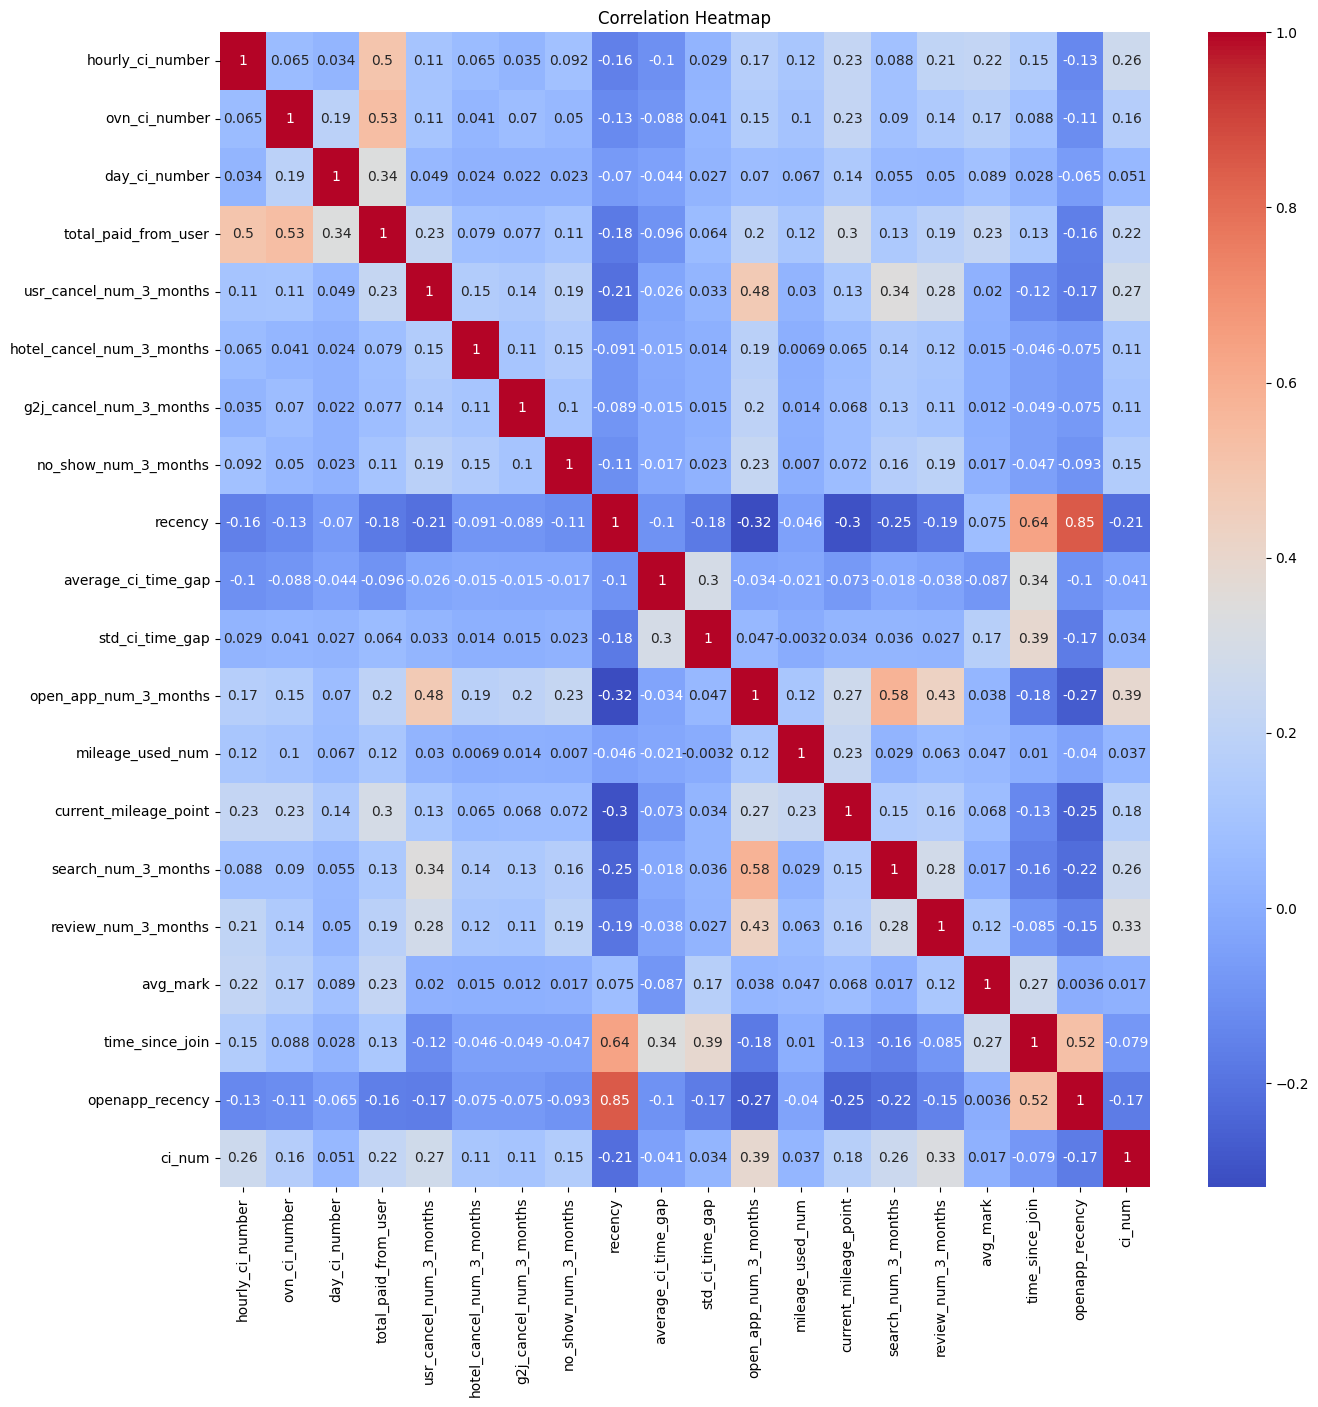

In [104]:
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

#### Ranking of numerical features that are positively correlated with check-in in July.2024

In [36]:
positive_corr = corr_matrix[corr_matrix['ci_num']>0]['ci_num'][:-1]
positive_corr.sort_values(ascending=False)

open_app_num_3_months        0.390423
review_num_3_months          0.326673
usr_cancel_num_3_months      0.274468
hourly_ci_number             0.260036
search_num_3_months          0.255742
total_paid_from_user         0.221350
current_mileage_point        0.175616
ovn_ci_number                0.162417
no_show_num_3_months         0.154782
hotel_cancel_num_3_months    0.114128
g2j_cancel_num_3_months      0.105073
day_ci_number                0.051069
mileage_used_num             0.036766
std_ci_time_gap              0.033913
avg_mark                     0.017054
Name: ci_num, dtype: float64

#### Ranking of numerical features that are negatively correlated with check-in in July.2024

In [37]:
negative_corr = corr_matrix[corr_matrix['ci_num']<=0]['ci_num'][:-1]
negative_corr.sort_values(ascending=True)

recency               -0.214107
time_since_join       -0.078638
average_ci_time_gap   -0.041217
Name: ci_num, dtype: float64

## correlations between features ranking

In [111]:
features_corr_li = []

columns = corr_matrix.columns
for feature1 in corr_matrix.columns:
    feature_corr = corr_matrix[feature1]
    for i, feature2 in enumerate(feature_corr.index):
        if feature1 != feature2:
            features_corr_li.append((f'{feature1} x {feature2}', feature_corr.values[i]))


In [120]:
features_pos_corr = list(filter(lambda x: x[1]>0, features_corr_li))
features_neg_corr = list(filter(lambda x: x[1]<0, features_corr_li))

#### Top 10 numerical features that are positively correlated

In [125]:
features_pos_corr_df = pd.DataFrame(features_pos_corr, columns=['feature1_x_feature2', 'correlation_score']).drop_duplicates(subset=['correlation_score'], keep='first')
features_pos_corr_df.sort_values(by='correlation_score', ascending=False)[:10]

,feature1_x_feature2,correlation_score
126,recency x openapp_recency,0.846739
125,recency x time_since_join,0.635008
156,open_app_num_3_months x search_num_3_months,0.581854
18,ovn_ci_number x total_paid_from_user,0.533376
247,time_since_join x openapp_recency,0.522150
2,hourly_ci_number x total_paid_from_user,0.502698
72,usr_cancel_num_3_months x open_app_num_3_months,0.475412
157,open_app_num_3_months x review_num_3_months,0.432286
143,std_ci_time_gap x time_since_join,0.391701
159,open_app_num_3_months x ci_num,0.390423


#### Top 10 numerical features that are negatively correlated

In [126]:
features_neg_corr_df = pd.DataFrame(features_neg_corr, columns=['feature1_x_feature2', 'correlation_score']).drop_duplicates(subset=['correlation_score'], keep='first')
features_neg_corr_df.sort_values(by='correlation_score', ascending=True)[:10]

,feature1_x_feature2,correlation_score
38,recency x open_app_num_3_months,-0.318878
40,recency x current_mileage_point,-0.299560
67,open_app_num_3_months x openapp_recency,-0.269991
41,recency x search_num_3_months,-0.250855
75,current_mileage_point x openapp_recency,-0.247093
79,search_num_3_months x openapp_recency,-0.220375
43,recency x ci_num,-0.214107
12,usr_cancel_num_3_months x recency,-0.209189
42,recency x review_num_3_months,-0.191294
66,open_app_num_3_months x time_since_join,-0.179629


### Segmentation feature

In [86]:
categorical_df = cleaned_df[['user_province', 'segmentation_text', 'ci_or_not']]

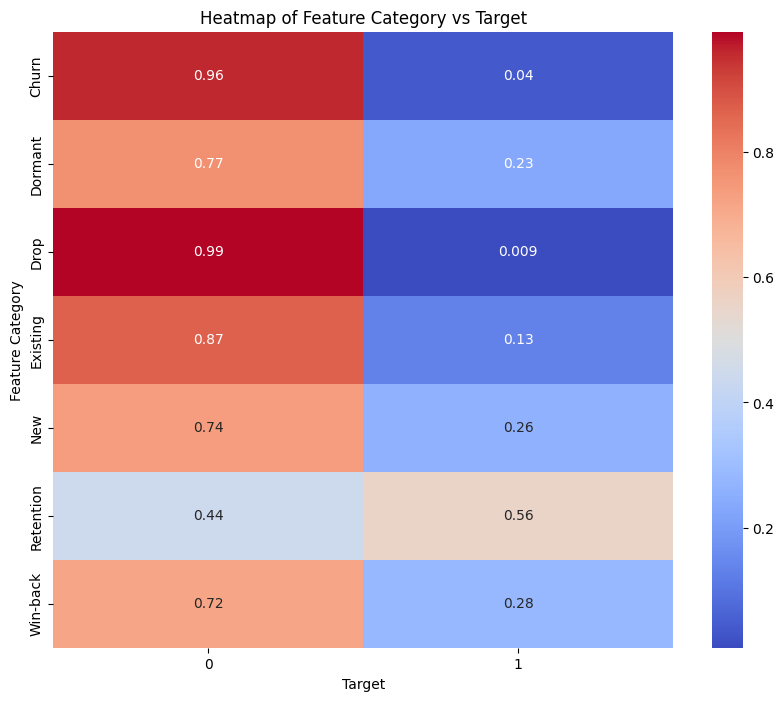

In [91]:
# Cross-tabulation
crosstab = pd.crosstab(categorical_df['segmentation_text'], categorical_df['ci_or_not'], normalize='index')

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, cmap='coolwarm')
plt.title('Heatmap of Feature Category vs Target')
plt.ylabel('Feature Category')
plt.xlabel('Target')
plt.show()

- As expected, users that have segmentation that signify they check in in June are more like to check in in July 2024

### Feature importance

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = cleaned_df.drop(columns=['user_sn','segmentation', 'ci_or_not', 'ci_num'],axis=1)
y = cleaned_df['ci_or_not']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)

num_features = X_train.select_dtypes(exclude="object").columns
cat_features = X_train.select_dtypes(include="object").columns

print('We have {} numerical features : {}'.format(len(num_features), num_features))
print('\nWe have {} categorical features : {}'.format(len(cat_features), cat_features))

We have 19 numerical features : Index(['hourly_ci_number', 'ovn_ci_number', 'day_ci_number',
       'total_paid_from_user', 'usr_cancel_num_3_months',
       'hotel_cancel_num_3_months', 'g2j_cancel_num_3_months',
       'no_show_num_3_months', 'recency', 'average_ci_time_gap',
       'std_ci_time_gap', 'open_app_num_3_months', 'mileage_used_num',
       'current_mileage_point', 'search_num_3_months', 'review_num_3_months',
       'avg_mark', 'time_since_join', 'openapp_recency'],
      dtype='object')

We have 2 categorical features : Index(['user_province', 'segmentation_text'], dtype='object')


In [55]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
oh_transformer = OneHotEncoder()
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),    
        ('pass', 'passthrough', num_features)
    ]
)

In [56]:
from sklearn.ensemble import RandomForestClassifier

class_weight = {0: 1, 1: 10} 
rf = RandomForestClassifier(n_estimators=150, min_samples_split=7, min_samples_leaf=5, criterion='gini',
                            max_features='sqrt', max_samples=0.8, bootstrap=True, class_weight=class_weight, random_state=2)

processed_X_train = preprocessor.fit_transform(X_train)
processed_X_test = preprocessor.transform(X_test)


rf.fit(processed_X_train, y_train) 

y_test_pred = rf.predict(processed_X_test)

report = classification_report(y_test, y_test_pred)
print("Test Classification Report:")
print(report)

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     48452
           1       0.42      0.71      0.53      4565

    accuracy                           0.89     53017
   macro avg       0.70      0.81      0.73     53017
weighted avg       0.92      0.89      0.90     53017



### top 10 features that are most important for the model to make decision

In [76]:
ohe_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['user_province','segmentation_text'])
numeric_feature_names = preprocessor.transformers_[1][2]

# Combine all feature names
feature_names = list(ohe_feature_names) + list(numeric_feature_names)

# Get feature importances
feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df[:10].reset_index(drop=True)

,Feature,Importance
0,recency,0.186802
1,openapp_recency,0.152131
2,open_app_num_3_months,0.132949
3,search_num_3_months,0.080160
4,segmentation_text_Retention,0.050095
5,current_mileage_point,0.050005
6,segmentation_text_Drop,0.045582
7,total_paid_from_user,0.040750
8,average_ci_time_gap,0.031658
9,std_ci_time_gap,0.031542
